In [ ]:
!pip install ultralytics
!pip install segmentation-models-pytorch

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 154.8/154.8 kB 5.9 MB/s eta 0:00:00


In [ ]:
from ultralytics import YOLO
import cv2
import matplotlib.pyplot as plt

# Load YOLO segmentation model
model = YOLO("yolov8l-seg.pt")  # or yolov8n-seg.pt


In [ ]:
image_path = "//content/download.jpg"
results = model(image_path)



image 1/1 //content/download.jpg: 640x448 1 person, 1 handbag, 280.6ms
Speed: 29.9ms preprocess, 280.6ms inference, 816.5ms postprocess per image at shape (1, 3, 640, 448)


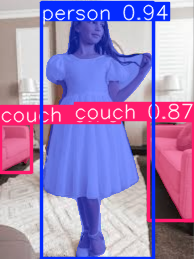

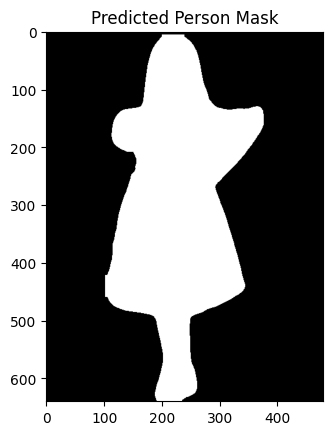

In [ ]:
results[0].show()

masks = results[0].masks
if masks is not None:
    mask_array = masks.data[0].cpu().numpy()
    plt.imshow(mask_array, cmap="gray")
    plt.title("Predicted Person Mask")
    plt.show()


Img1_mask


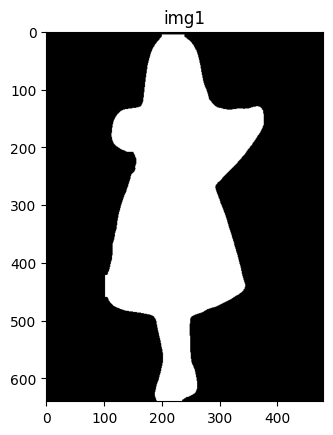

In [ ]:
import cv2
import numpy as np

masks = results[0].masks
if masks is not None:
    mask_array = masks.data[0].cpu().numpy()
    binary_mask = (mask_array > 0.5).astype(np.uint8) * 255
    cv2.imwrite("person_mask_Yolo.png", binary_mask)
    print("Img1_mask")

    import matplotlib.pyplot as plt
    plt.imshow(binary_mask, cmap="gray")
    plt.title("img1")
    plt.show()


Background mask saved as /content/background_mask.png


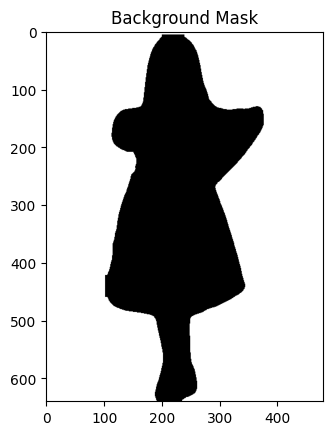

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the combined mask
person_mask = cv2.imread("/content/person_mask_Yolo.png", cv2.IMREAD_GRAYSCALE)

background_mask = cv2.bitwise_not(person_mask)

cv2.imwrite("/content/background_mask.png", background_mask)
print("Background mask saved as /content/background_mask.png")

# Display
plt.imshow(background_mask, cmap="gray")
plt.title("Background Mask")
plt.show()


In [ ]:
import torch
import segmentation_models_pytorch as smp

num_classes = 14
device = "cuda" if torch.cuda.is_available() else "cpu"

# Define U-Net
model_Seg = smp.Unet(
    encoder_name="resnet34",
    encoder_weights="imagenet",
    in_channels=3,
    classes=num_classes
)

# Load your trained weights
model_Seg.load_state_dict(torch.load("/content/drive/MyDrive/Modified_With_Lossfunctions.pth", map_location=device))
model_Seg.to(device)
model_Seg .eval()



/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Unet(
  (encoder): ResNetEncoder(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track

Combined clothes mask saved as /content/clothes_mask.png


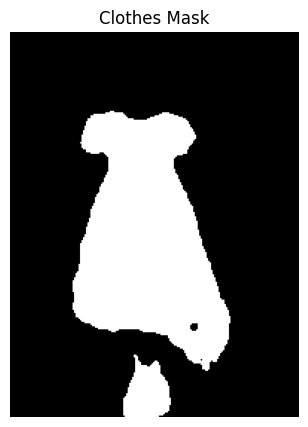

In [ ]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt


image_path = "/content/download.jpg"
image = Image.open(image_path).convert("RGB")
orig_size = image.size  # (width, height)

transform = T.Compose([
    T.Resize((256, 256)),   # resize to match model input
    T.ToTensor(),

])
input_tensor = transform(image).unsqueeze(0).to(device)  # [1, 3, H, W]

with torch.no_grad():
    output = model_Seg (input_tensor)  # [1, num_classes, H, W]

    output_resized = torch.nn.functional.interpolate(
        output, size=(orig_size[1], orig_size[0]), mode='nearest'
    )

    # Get predicted mask
    pred_mask = torch.argmax(output_resized, dim=1).squeeze(0).cpu().numpy()  # [H, W]

clothes_classes = list(range(1, 14))
clothes_mask = np.isin(pred_mask, clothes_classes).astype(np.uint8) * 255

clothes_mask_img = Image.fromarray(clothes_mask)
clothes_mask_img.save("/content/clothes_mask.png")
print("Combined clothes mask saved as /content/clothes_mask.png")

plt.figure(figsize=(5, 5))
plt.imshow(clothes_mask_img, cmap="gray")
plt.title("Clothes Mask")
plt.axis("off")
plt.show()


In [ ]:
import torch
from diffusers import AutoPipelineForInpainting
from PIL import Image

pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16
).to("cuda")
image = Image.open("/content/download.jpg")
mask_image = Image.open("/content/background_mask.png")
prompt = """
Replace the background with a peaceful forest path surrounded by tall trees,
green foliage, and filtered sunlight streaming through the branches.
Keep the girl, her pose, face, and clothes unchanged.
Make the scene look bright and naturally lit.
"""


output = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
output.save("/content/img6_background.png")
output.show()
print("Girl's dress inpainted successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/49 [00:00<?, ?it/s]

Girl's dress inpainted successfully!


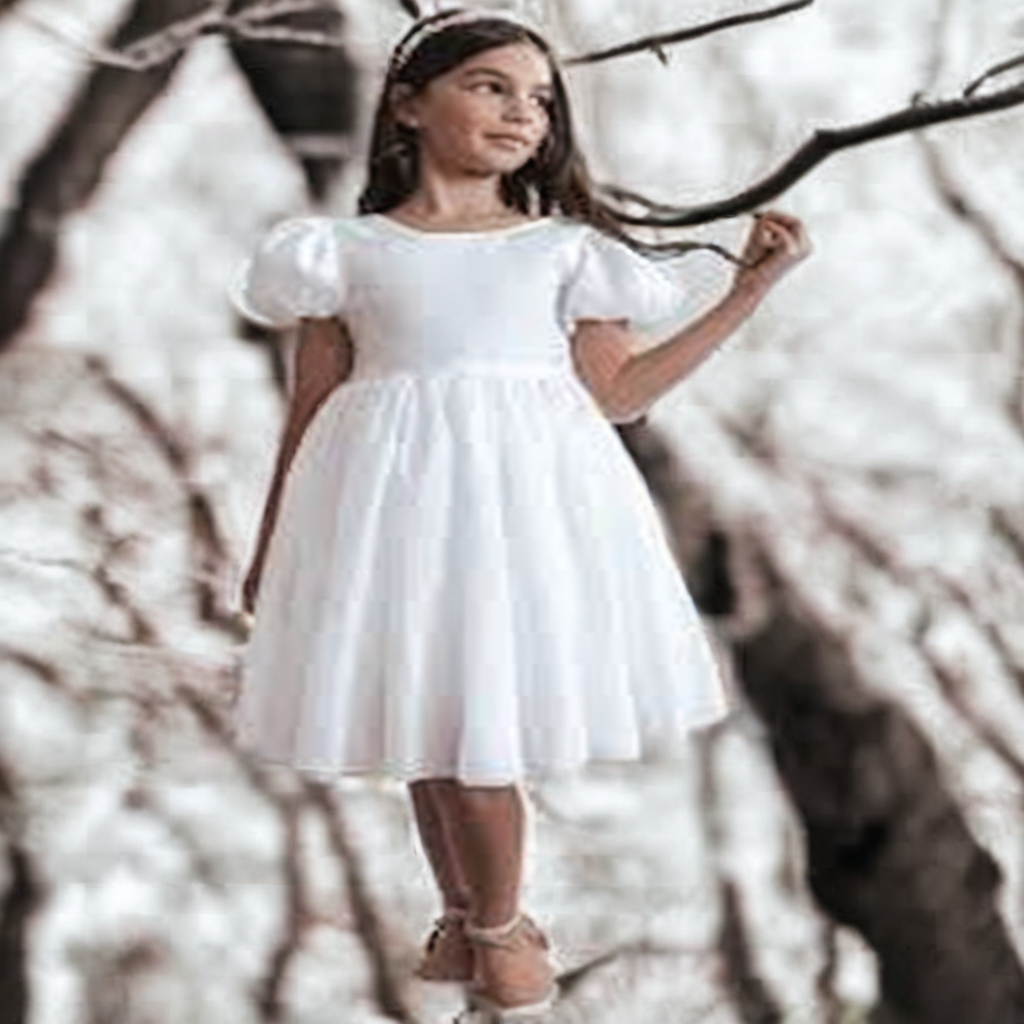

In [ ]:
from IPython.display import Image, display

display(Image(filename="/content/img6_background.png"))


In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")


image = Image.open("/content/img6_background.png")
mask_image = Image.open("/content/clothes_mask.png")  # clothes=white, everything else=black


prompt = """
replace the girl dress with a Yellow long dress with stars pattern like, make shooes color green
"""


output = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]


output.save("/content/girl_new_clothes6.png")
print(" Girl clothes inpainted successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

 Girl clothes inpainted successfully!


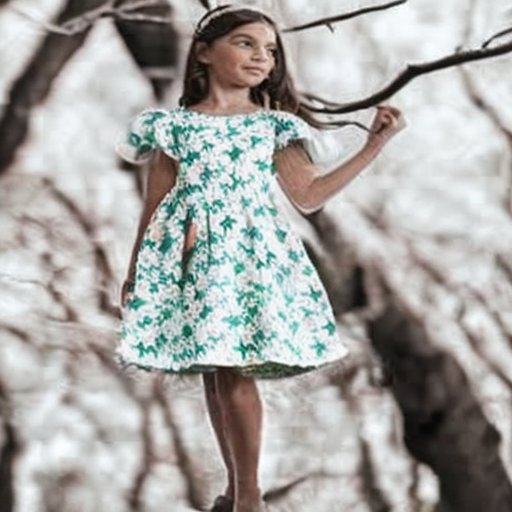

In [ ]:
from IPython.display import Image, display

display(Image(filename="/content/girl_new_clothes6.png"))


In [ ]:
image_path = "/content/download.jpg"
results = model(image_path)



image 1/1 /content/download.jpg: 640x544 1 person, 1 dog, 2 beds, 114.4ms
Speed: 16.4ms preprocess, 114.4ms inference, 292.7ms postprocess per image at shape (1, 3, 640, 544)


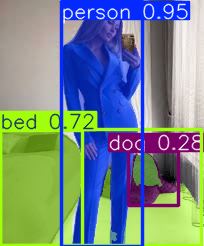

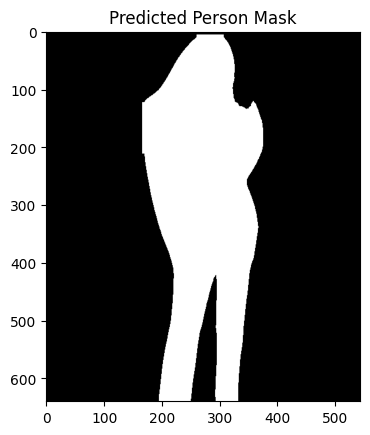

In [ ]:
results[0].show()

masks = results[0].masks
if masks is not None:
    mask_array = masks.data[0].cpu().numpy()
    plt.imshow(mask_array, cmap="gray")
    plt.title("Predicted Person Mask")
    plt.show()


Img1_mask


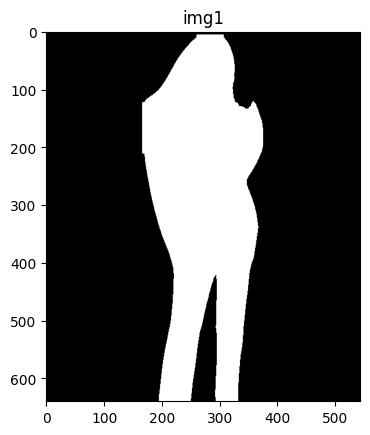

In [ ]:
import cv2
import numpy as np

masks = results[0].masks
if masks is not None:
    mask_array = masks.data[0].cpu().numpy()
    binary_mask = (mask_array > 0.5).astype(np.uint8) * 255
    cv2.imwrite("person_mask_Yolo.png", binary_mask)
    print("Img1_mask")

    import matplotlib.pyplot as plt
    plt.imshow(binary_mask, cmap="gray")
    plt.title("img1")
    plt.show()


Background mask saved as /content/background_mask.png


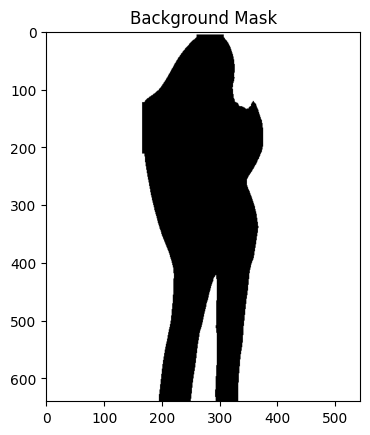

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the combined mask
person_mask = cv2.imread("/content/person_mask_Yolo.png", cv2.IMREAD_GRAYSCALE)

background_mask = cv2.bitwise_not(person_mask)

cv2.imwrite("/content/background_mask.png", background_mask)
print("Background mask saved as /content/background_mask.png")

# Display
plt.imshow(background_mask, cmap="gray")
plt.title("Background Mask")
plt.show()


Combined clothes mask saved as /content/clothes_mask.png


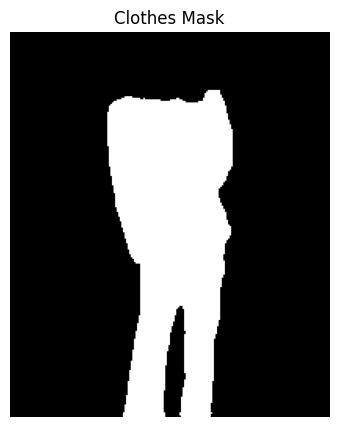

In [ ]:
import torch
import numpy as np
from PIL import Image
import torchvision.transforms as T
import matplotlib.pyplot as plt


image_path = "/content/download.jpg"
image = Image.open(image_path).convert("RGB")
orig_size = image.size  # (width, height)

transform = T.Compose([
    T.Resize((256, 256)),
    T.ToTensor(),

])
input_tensor = transform(image).unsqueeze(0).to(device)

with torch.no_grad():
    output = model_Seg (input_tensor)

    output_resized = torch.nn.functional.interpolate(
        output, size=(orig_size[1], orig_size[0]), mode='nearest'
    )

    pred_mask = torch.argmax(output_resized, dim=1).squeeze(0).cpu().numpy()

clothes_classes = list(range(1, 14))
clothes_mask = np.isin(pred_mask, clothes_classes).astype(np.uint8) * 255

clothes_mask_img = Image.fromarray(clothes_mask)
clothes_mask_img.save("/content/clothes_mask.png")
print("Combined clothes mask saved as /content/clothes_mask.png")

plt.figure(figsize=(5, 5))
plt.imshow(clothes_mask_img, cmap="gray")
plt.title("Clothes Mask")
plt.axis("off")
plt.show()


In [ ]:
import torch
from diffusers import AutoPipelineForInpainting
from PIL import Image

pipe = AutoPipelineForInpainting.from_pretrained(
    "diffusers/stable-diffusion-xl-1.0-inpainting-0.1",
    torch_dtype=torch.float16
).to("cuda")
image = Image.open("/content/download.jpg")
mask_image = Image.open("/content/background_mask.png")
prompt = """
replace background with a warm beach and sand
"""


output = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]
output.save("/content/img1_background.png")
output.show()
print("Girl's dress inpainted successfully!")


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!
The config attributes {'decay': 0.9999, 'inv_gamma': 1.0, 'min_decay': 0.0, 'optimization_step': 37000, 'power': 0.6666666666666666, 'update_after_step': 0, 'use_ema_warmup': False} were passed to UNet2DConditionModel, but are not expected and will be ignored. Please verify your config.json configuration file.


  0%|          | 0/49 [00:00<?, ?it/s]

Girl's dress inpainted successfully!


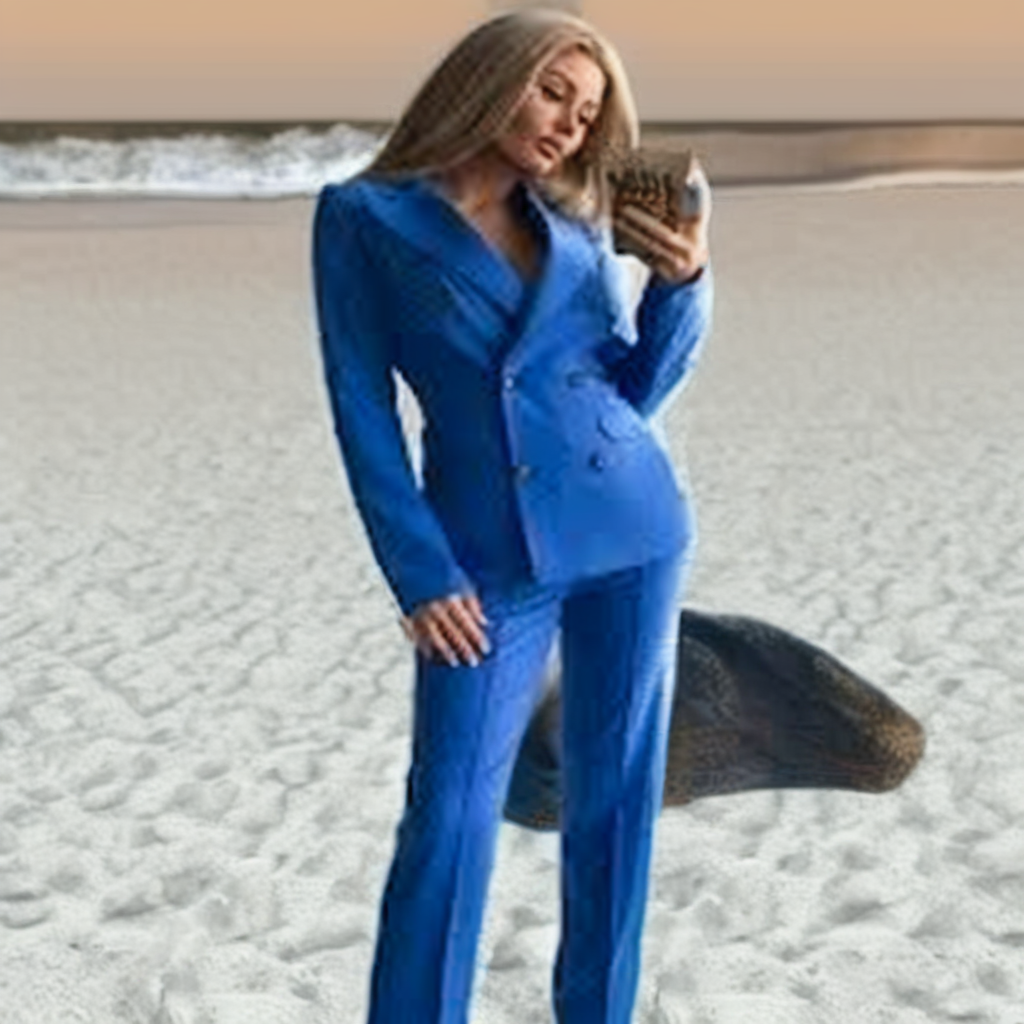

In [ ]:
from IPython.display import Image, display

display(Image(filename="/content/img1_background.png"))


In [ ]:
from diffusers import StableDiffusionInpaintPipeline
import torch
from PIL import Image

pipe = StableDiffusionInpaintPipeline.from_pretrained(
    "stabilityai/stable-diffusion-2-inpainting",
    torch_dtype=torch.float16,
)
pipe.to("cuda")


image = Image.open("/content/img1_background.png")
mask_image = Image.open("/content/clothes_mask.png")  # clothes=white, everything else=black


prompt = """
change the girl's blouse to red colour, and her pants change the colour to white colour.
Change the color of her shoes to Green.
"""


output = pipe(prompt=prompt, image=image, mask_image=mask_image).images[0]


output.save("/content/girl_new_clothes.png")
print(" Girl clothes inpainted successfully!")


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

`torch_dtype` is deprecated! Use `dtype` instead!


  0%|          | 0/50 [00:00<?, ?it/s]

 Girl clothes inpainted successfully!


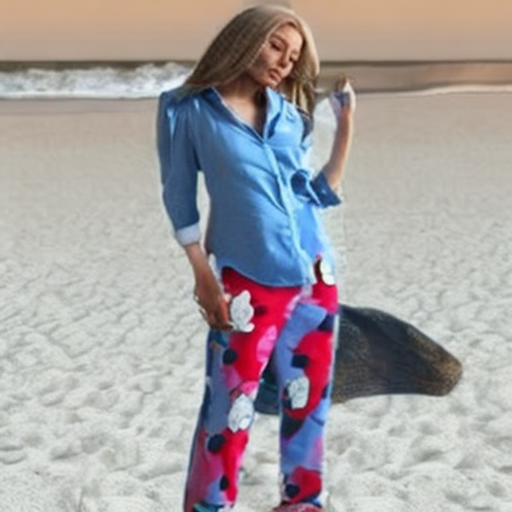

In [ ]:
from IPython.display import Image, display

display(Image(filename="/content/girl_new_clothes.png"))
